In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd

import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [2]:
class cfg:
    data_dir = '/opt/ml/input/data/train'  
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [3]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [5]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


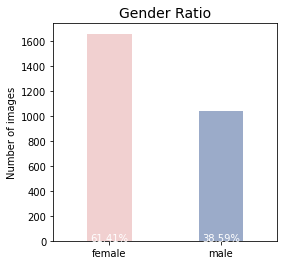

In [6]:
plt.figure(figsize=(4, 4)) 
ax = sns.countplot(x = 'gender', data = df, palette=["#F7CACA", "#93A9D1"], width = 0.4)

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Gender Ratio', fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]

for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 10, color = 'w')
    
plt.show()

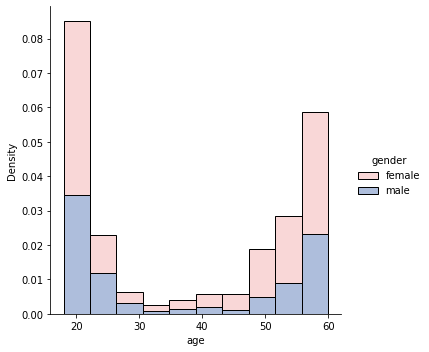

In [7]:
sns.displot(df, x= "age",
            hue= "gender", 
            palette= ["#F7CACA", "#93A9D1"] ,
            stat= "density",
            multiple= 'stack',
            bins= 10)

plt.show()

In [8]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

In [9]:
# print(df.iloc[100])

In [10]:
# print(min(df['age']))
# print(max(df['age']))

In [11]:
Female_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }
Male_Age = {"~20" : 0, "20~29" : 0, "30~39" : 0, "40~49" : 0, "50~59" : 0, "60~" : 0 }

for idx in range(len(df)) :
    person = df.iloc[idx]
    if person['gender'] == 'female' :
        if person['age'] <= 20 : Female_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Female_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Female_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Female_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Female_Age["50~59"] += 1
        elif 60 <= person['age'] : Female_Age["60~"] += 1
    elif person['gender'] == 'male' :
        if person['age'] <= 20 : Male_Age["~20"] += 1
        elif 20 < person['age'] < 30 : Male_Age["20~29"] += 1
        elif 30 < person['age'] < 40 : Male_Age["30~39"] += 1
        elif 40 < person['age'] < 50 : Male_Age["40~49"] += 1
        elif 50 < person['age'] < 60 : Male_Age["50~59"] += 1
        elif 60 <= person['age'] : Male_Age["60~"] += 1


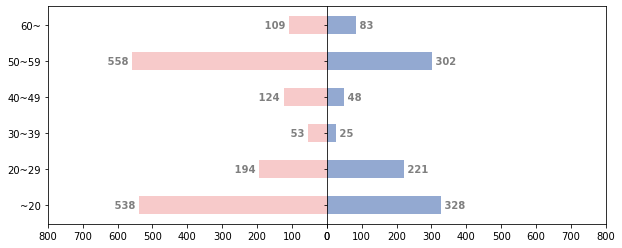

In [23]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4), gridspec_kw={"wspace":0})

female = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
female_values = list(Female_Age.values())
axs[0].barh(female, female_values, color="#F7CACA", height = 0.5)

male = np.array(("~20", "20~29", "30~39", "40~49", "50~59", "60~"))
male_values = list(Male_Age.values())
axs[1].barh(male, male_values, color="#93A9D1", height = 0.5)

xmax = 800
axs[0].set_xlim(xmax, 0)
axs[1].set_xlim(0, xmax)

for ax in axs:
    for i, p in enumerate(ax.patches):
        w = p.get_width()
        if ax == axs[0]:
            ha = "right"
        else:
            ha = "left"
        
        ax.text(w, i, f" {format(w, ',')} ", 
                fontsize=10, va="center", ha=ha, 
                fontweight="bold", alpha=0.5)

plt.show()

In [13]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# print(face_cascade.empty())

In [14]:
image_file = {'incorrect_mask' : 0,
             'mask1' : 0,
             'mask2' : 0,
             'mask3' : 0,
             'mask4' : 0,
             'mask5' : 0,
             'normal' : 0}

In [15]:
imgs = []
bboxes = []
file_extension = {}
sum_not_founded = 0

for x in range(len(df)) :
    img_id = df.iloc[x].path
    filename = os.listdir(os.path.join(cfg.img_dir, img_id))
    
#     ext = get_ext(cfg.img_dir, img_id)

    for i, class_id in enumerate(num2class):
        try :
            ext = os.path.splitext(filename[i])[-1]
            if ext not in file_extension.keys() :
                file_extension[ext] = 1
            else :
                file_extension[ext] += 1
            img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
            bbox = face_cascade.detectMultiScale(img)
            imgs.append(img)
            if len(bbox) != 0:
                bboxes.append(bbox.max(axis=0))
            else:
                image_file[class_id] += 1
        except : 
            print(cfg.img_dir, img_id, class_id+ext)
        
    if x % 200 == 0 : print("진행도:", x, "/", len(df))
print()

for _, class_id in enumerate(num2class) :
    sum_not_founded += image_file[class_id]
    
print("Unclassified images: ", sum_not_founded)

진행도: 0 / 2700
진행도: 200 / 2700
진행도: 400 / 2700
진행도: 600 / 2700
진행도: 800 / 2700
진행도: 1000 / 2700
진행도: 1200 / 2700
진행도: 1400 / 2700
진행도: 1600 / 2700
진행도: 1800 / 2700
진행도: 2000 / 2700
진행도: 2200 / 2700
진행도: 2400 / 2700
/opt/ml/input/data/train/images 006578_male_Asian_19 incorrect_mask.jpg
/opt/ml/input/data/train/images 006578_male_Asian_19 mask5.jpeg
/opt/ml/input/data/train/images 006580_female_Asian_20 incorrect_mask.jpg
/opt/ml/input/data/train/images 006580_female_Asian_20 mask5.jpeg
/opt/ml/input/data/train/images 006582_female_Asian_20 incorrect_mask.jpg
/opt/ml/input/data/train/images 006582_female_Asian_20 mask5.jpeg
/opt/ml/input/data/train/images 006584_female_Asian_20 incorrect_mask.jpg
/opt/ml/input/data/train/images 006584_female_Asian_20 mask5.jpeg
/opt/ml/input/data/train/images 006589_female_Asian_20 incorrect_mask.jpg
/opt/ml/input/data/train/images 006589_female_Asian_20 mask5.jpeg
/opt/ml/input/data/train/images 006626_male_Asian_19 mask1.jpeg
/opt/ml/input/data/train/i

In [25]:
print(file_extension)

{'.jpg': 18035, '.png': 511, '.jpeg': 354}


In [16]:
rate = round(sum_not_founded / 189, 2)
print(f"detection rate: {rate}%")

for class_id in image_file.keys() :
    rate = round(image_file[class_id] / 27, 2)
    print(f"{class_id}: {rate}%({image_file[class_id]})")

detection rate: 33.6%
incorrect_mask: 36.74%(992)
mask1: 44.33%(1197)
mask2: 29.85%(806)
mask3: 47.7%(1288)
mask4: 34.56%(933)
mask5: 41.52%(1121)
normal: 0.48%(13)


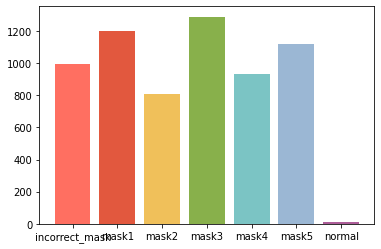

In [20]:
x = np.arange(7)
keys = list(image_file.keys())
values = list(image_file.values())
colors = ["#FF6F61", "#E2583E", "#F0C05A", "#88B04B", "#7BC4C4", "#9BB7D4", "#AD5E99"]

plt.bar(x, values, width=0.8, color = colors)
plt.xticks(x, keys)

plt.show()